In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from helper_classifier import set_seed

import os
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoModel
import numpy as np
from tqdm.notebook import tqdm
import random

torch.set_printoptions(sci_mode=False)
from helpers_pipeline import *
from helper_DinoV2_Embeddings import set_device

set_seed(42)

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


### General Setup

In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
dino_device, sg2_device, device = set_device()
target_feature = "category"

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


### Model Setups

In [4]:
# Products data and latents
df, latents = load_latents()
latents = latents.to(sg2_device)

# id2label 
id2label = pickle.load(open(f"{current_wd}/id2label_dicts/{target_feature}_id2label.pkl", "rb"))
label2id = {v:k for k,v in id2label.items()}
df["label"] = df[target_feature].map(label2id)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier = load_classifier()
classifier = classifier.to(device)

In [5]:


# import threading
# import time
# def first_sg2_setup():
#     try:
#         z = torch.randn([1, G.z_dim]).to(device)  
#         img = G(z, None)
#     except: 
#         print("Error")


# def run_with_timeout(timeout_sec):
#     # Create a thread to run the potentially hanging function
#     thread = threading.Thread(target=first_sg2_setup)
    
#     # Start the thread
#     thread.start()
    
#     # Wait for the specified timeout
#     thread.join(timeout=timeout_sec)
    
#     # Check if thread is still alive (it is hanging if alive)
#     if thread.is_alive():
#         print(f"Function did not finish within {timeout_sec} seconds, stopping thread.")
#         thread._stop()  # This is discouraged and not safe in production code

# # Example usage
# run_with_timeout(5)  # Set your desired timeout in seconds

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/dinov2/lib/python3.9/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/

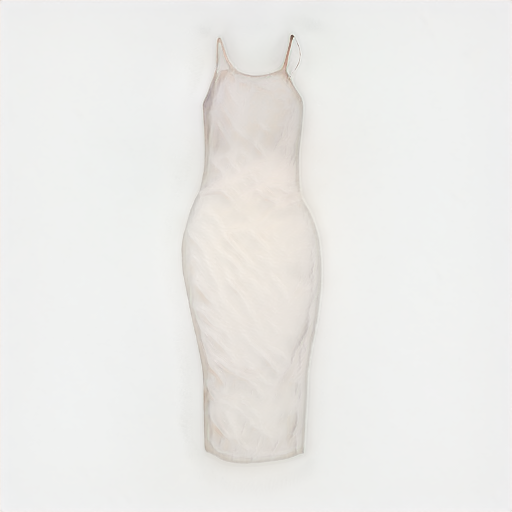

In [6]:
z = torch.randn([1, G.z_dim]).to(device)  
img = G(z, None)
img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

In [ ]:
# # Check correct functioning of all components
# sample = df.sample(1)
# sku = sample.sku.values[0]
# latent_idx = sample.latent_idx.values[0]

# # Generate image
# w = latents[latent_idx]
# img = G.synthesis(w)
# img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
# img_out = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

# # Load real image
# img_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{sku}.jpg"
# img_real = Image.open(img_path).resize((512, 512))

# # Compare images
# fig, ax  = plt.subplots(1, 2)
# ax[0].imshow(img_real)
# ax[1].imshow(img_out)
# ax[0].axis('off')
# ax[1].axis('off')
# plt.show()


### Validation Pipeline: 
Goal: Compare performance of the attribute scoring model between the actual images and the reconstructed images from latent space using SG2-Ada dress generator

Steps: 
1. Generate recosnstruction from latent space using SG2-Ada dress generator
2. Load real image
3. Get top3 predictions and probabilities for the real image
4. Get top3 predictions and probabilities for the reconstructed image


In [7]:
from IPython.utils import io
n = 3

for i in tqdm(df.index):
    latent_idx = df.loc[i].latent_idx.item()
    sku = df.loc[i].sku

    # Generate image
    w = latents[latent_idx]
    #w = w.to(device)
    with io.capture_output() as captured: # Capture pytorch plugins warnings due to wrong virtualenv for SG2 model
        img_gen = G.synthesis(w);
    #print(img_gen.shape)
    #display(img_gen)
    #print('First generation done')

    # Load real image
    img_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{sku}.jpg"

    # Get scores for both images
    scores_gen = get_attribute_scores(dino_model, dino_processor, classifier, img_gen)
    scores_real = get_attribute_scores(dino_model, dino_processor, classifier, img_path)

    prob_gen, predicted_gen = torch.topk(scores_gen, n)
    prob_real, predicted_real = torch.topk(scores_real, n)

    for j in range(n):
        df.loc[i, f'gen_predicted_label_{j+1}'] = predicted_gen[j].item()
        df.loc[i, f'gen_predicted_prob_{j+1}'] = prob_gen[j].item()
        df.loc[i, f'real_predicted_label_{j+1}'] = predicted_real[j].item()
        df.loc[i, f'real_predicted_prob_{j+1}'] = prob_real[j].item()
        
    # Save every 10 iterations
    if i % 500 == 0:
        #print(f"Saving predictions after {i} iterations")
        df.to_csv('predictions.csv', index=False)

for i in range(n):
    df[f"gen_predicted_category_{i+1}"] = df[f"gen_predicted_label_{i+1}"].map(id2label)
    df[f"real_predicted_category_{i+1}"] = df[f"real_predicted_label_{i+1}"].map(id2label)
df.to_csv('predictions.csv', index=False)

  0%|          | 0/14060 [00:00<?, ?it/s]

In [8]:
df = pd.read_csv('predictions.csv')

In [9]:
def isin_first_n(row, n, type):
    label = row['label']
    preds = row[[f'{type}_predicted_label_{i+1}' for i in range(n)]].values
    return label in preds

for type in ['gen', 'real']:
    for i in range(1,n+1):
        df[f'isin_top{i}_{type}'] = df.apply(lambda x: isin_first_n(x, i, type), axis=1)



for type in ['gen', 'real']:
    print(f"\n{type.upper()}")
    for i in range(1,n+1):
        print(f"Top {i}: {df[f'isin_top{i}_{type}'].mean()*100}%")


GEN
Top 1: 24.921763869132292%
Top 2: 45.440967283072546%
Top 3: 60.10668563300142%

REAL
Top 1: 80.85348506401138%
Top 2: 94.4167852062589%
Top 3: 98.23613086770982%
